In [1]:
%cd ..

/media/Windows/Users/white/Documents/UTD/Fall19/NLP.6320.501/Project/STS-Project


In [2]:
import json

import numpy as np
import pandas as pd
import scipy.sparse
from scipy.stats import pearsonr
from sklearn.feature_extraction.text import TfidfVectorizer

from sts_wrldom.corpusReader import read_data
from sts_wrldom.enrichPipe import preprocess_raw
from sts_wrldom.depTFIDFModel import depFit_Predict
from sts_wrldom.utils import log_frame, accuracy, get_scores, rmse, write_results

In [3]:
dfs = read_data(["dev", "train"])
dev = dfs["dev"]
train = dfs["train"]
dev_train = dev.append(train)

dev_docs = preprocess_raw(dfs["dev"])
train_docs = preprocess_raw(dfs["train"])
dev_train_docs = dev_docs + train_docs

Reading dev-set from: data/dev-set.txt
Dev DF shape: (1209, 4)
Dev Pairs Omitted: 0 = 1209 - 1209

Reading train-set from: data/train-set.txt
Train DF shape: (1484, 4)
Train Pairs Omitted: 0 = 1484 - 1484

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0

Enriching data from dataframe...
S1 parse failures: 0
S2 parse failures: 0



In [4]:
dev_predics = depFit_Predict(dev_docs)
train_predics = depFit_Predict(train_docs)
dev_train_predics = depFit_Predict(dev_train_docs)

dev["prediction"] = [int(elem) for elem in np.round(dev_predics)]
train["prediction"] = [int(elem) for elem in np.round(train_predics)]
dev_train["prediction"] = [int(elem) for elem in np.round(dev_train_predics)]

In [5]:
for df, name in zip([dev, train], ["dev", "train"]):
    log_frame(df, name=name, tag="depTFIDF_predics")

for df, name in zip([dev, train, dev_train], ["Dev", "Train", "Dev-Train"]):
    acc = accuracy(df["prediction"], df["gold"])
    _rmse = rmse(df["prediction"], df["gold"])
    pear_corr = pearsonr(list(df["prediction"]), list(df["gold"]))
    cols = ["RMSE", "Accuracy", "Pearson's R", "Pearson's R p-val"]
    vals = [_rmse, acc, pear_corr[0], pear_corr[1]]
    stats = pd.DataFrame(list(df["prediction"]), columns=["Predic_Label"]).describe()
    extra = pd.DataFrame(vals, index=cols, columns=["Predic_Label"])
    print(f"\n{name} Gold stats: ")
    print(pd.DataFrame(list(df["gold"]), columns=["Gold_Label"]).describe().T)
    print(f"\n{name} depTFIDF Model Prediction stats: ")
    print(stats.append(extra).T)
    print("\n------")

for df, name in zip([dev, train, dev_train], ["Dev", "Train", "Dev-Train"]):
    print(f"\n{name} Prediction Metrics:")
    metrics = get_scores(list(df["prediction"]), list(df["gold"]))
    print(json.dumps(metrics, indent=2))


Dev Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1209.0  3.816377  1.063869  1.0  3.0  4.0  5.0  5.0

Dev depTFIDF Model Prediction stats: 
               count     mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1209.0  3.93962  0.695654  1.0  4.0  4.0  4.0  5.0  1.042917   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label   0.35732     0.366429       1.011558e-39  

------

Train Gold stats: 
             count      mean       std  min  25%  50%  75%  max
Gold_Label  1484.0  3.853774  0.999416  1.0  3.0  4.0  5.0  5.0

Train depTFIDF Model Prediction stats: 
               count      mean       std  min  25%  50%  75%  max      RMSE  \
Predic_Label  1484.0  3.922507  0.686096  1.0  4.0  4.0  4.0  5.0  0.955196   

              Accuracy  Pearson's R  Pearson's R p-val  
Predic_Label  0.431267     0.409273       5.081318e-61  

------

Dev-Train Gold stats: 
             count      mean       std  mi

In [6]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

labels = [1, 2, 3, 4, 5]

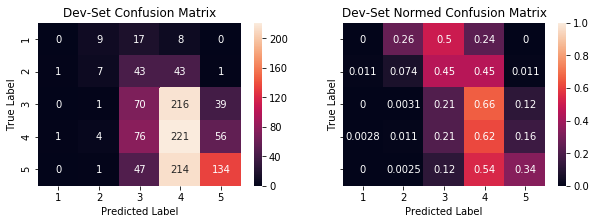

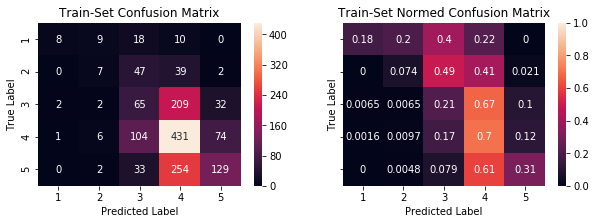

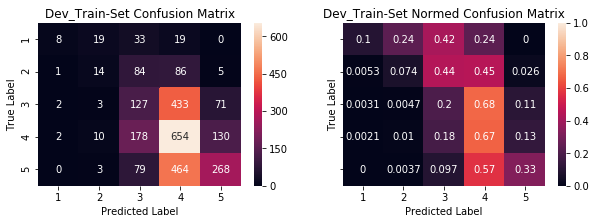

In [7]:
for df, name in zip([dev, train, dev_train], ["Dev-Set", "Train-Set", "Dev_Train-Set"]):
    cm = confusion_matrix(list(df["gold"]), list(df["prediction"]))
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)

    f,(ax1,ax2) = plt.subplots(1,2,sharey=True, figsize=(10,3))
    g1 = sns.heatmap(df_cm,annot=True, fmt='d', ax=ax1)
    g1.set_ylabel('True Label')
    g1.set_xlabel('Predicted Label')
    g1.set_title(f'{name} Confusion Matrix')

    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    df_cm_norm = pd.DataFrame(cm_norm, index=labels, columns=labels)
    g2 = sns.heatmap(df_cm_norm,annot=True, vmin=0, vmax=1, ax=ax2)
    g2.set_ylabel('True Label')
    g2.set_xlabel('Predicted Label')
    g2.set_title(f'{name} Normed Confusion Matrix')

In [8]:
for df, name in zip([dev, train], ["dev", "train"]):
    tmp = df[["id", "prediction"]]
    write_results(tmp, name, "depPredic")
    write_results(tmp, name, "depPredic")

In [9]:
for df, name in zip([dev, train], ["dev", "train"]):
    tmp = df[["id", "gold"]]
    write_results(tmp, name, "gold")
    write_results(tmp, name, "gold")